In [2]:
import xarray as xr
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
from pyresample.geometry import AreaDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
import cartopy 
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_cartesian(lat=None,lon=None):
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 1 #6371 # radius of the earth
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return x,y,z

In [4]:
def ian_closepoint2D(ref_lon_mat, ref_lat_mat, target_lon_pt, target_lat_pt):
    ref_x, ref_y, ref_z = get_cartesian(ref_lat_mat, ref_lon_mat)
    tg_x, tg_y, tg_z = get_cartesian(target_lat_pt, target_lon_pt)
    d = (ref_x - tg_x)**2 + (ref_y - tg_y)**2 + (ref_z - tg_z)**2
    i,j = np.where(d==np.min(d))
    i,j=i[0],j[0]
    #print(i,j)
    return i,j, d

In [4]:
# Loading Sea ice edge contours coordinates (FRSEAICE)

In [303]:
IceEdgeCoord = h5py.File('/Users/houndegno/Documents/MATLAB/Prog/SASSIE/FRSEAICE/Coords_sea_ice_edge_for_4days_v2.mat','r')
list(IceEdgeCoord.keys())

['Sea_ice_edge_FrSeaIce_lat', 'Sea_ice_edge_FrSeaIce_lon', 'TagTime']

In [304]:
Sea_ice_edge_FrSeaIce_lon = IceEdgeCoord['Sea_ice_edge_FrSeaIce_lon'][:]
Sea_ice_edge_FrSeaIce_lat = IceEdgeCoord['Sea_ice_edge_FrSeaIce_lat'][:]
TagTime                   = IceEdgeCoord['TagTime'][:]

In [305]:
## Conversition time variable into standard format -------------------------------------------#
#---------------------------------------------------------------------------------------------#
TagTime_stand_edge = " ".join(str(odi.odi_convert_wg_time_to_td64(TagTime[itime],\
                                        wg_ref=np.datetime64('0000-01-01')))[slice(0,10,1)]\
                        for itime in np.arange(TagTime.size)).split()
print(len(TagTime_stand_edge),'Is it equal to',np.array(TagTime).size,'? Check it!')

5 Is it equal to 5 ? Check it!


In [306]:
TagTime_stand_edge

['2022-09-09', '2022-09-25', '2022-09-30', '2022-10-05', '2022-10-09']

In [307]:
TagTime_stand = ['2022-09-25', '2022-09-30', '2022-10-05', '2022-10-09', '2022-10-12', '2022-10-18']

# Loading CTD data 

In [9]:
## SASSIE final data collected files directory ---------------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'#|
CastAway_CTD    = 'CastAway_CTD/SASSIE_Fall_2022_SHIPBOARD_Castaway_CTD.nc'#----------------|
ctd = xr.open_dataset(Final_SASSIE+CastAway_CTD)
lon_ctd = ctd.longitude
lat_ctd = ctd.latitude
time_ctd = ctd.time

In [10]:
Time_ctd = " ".join(str(np.array(time_ctd[i]))[slice(0,10,1)] for i in np.arange(time_ctd.size)).split()
np.unique(Time_ctd)

array(['2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12',
       '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16',
       '2022-09-17', '2022-09-18', '2022-09-19'], dtype='<U10')

In [162]:
Bon = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/ForcingData/New_Exp_forcing_data/"
Igoodvar  = xr.open_dataset(Bon+'iprof_good_indexes.nc').to_array().squeeze()
ESIgrowth = xr.open_dataset(Bon+'early_slow_ice_growth_indexes.nc').to_array().squeeze()
LFIgrowth = xr.open_dataset(Bon+'late_fast_ice_growth_indexes.nc').to_array().squeeze()

In [164]:
# Igoodvar

# Ice motion data

In [11]:
fic = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Ice_concentration/icemotion_daily_nh_25km_20220101_20221231_v4.1.nc"
ds = xr.open_dataset(fic)
ds

<xarray.Dataset>
Dimensions:                   (x: 361, y: 361, time: 365)
Coordinates:
  * x                         (x) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * y                         (y) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * time                      (time) object 2022-01-01 00:00:00 ... 2022-12-3...
Data variables:
    crs                       int32 ...
    u                         (time, y, x) float32 ...
    v                         (time, y, x) float32 ...
    icemotion_error_estimate  (time, y, x) float32 ...
    latitude                  (y, x) float32 ...
    longitude                 (y, x) float32 ...
Attributes:
    version:       4.1
    release_date:  Jun 2023
    Conventions:   CF-1.4
    dataset_doi:   10.5067/INAWUWO7QH7B

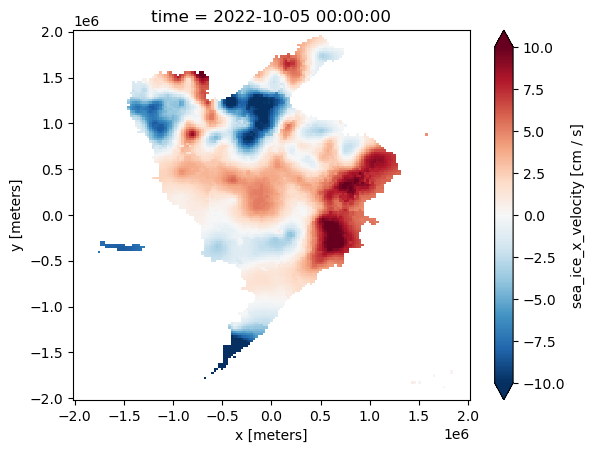

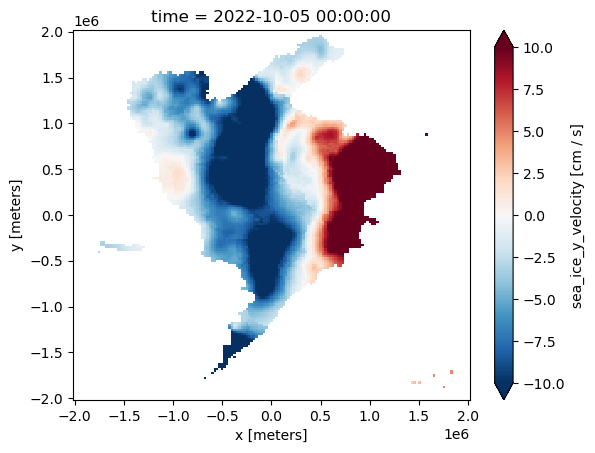

In [13]:
plt.figure();
ds.u[277][100:-100,100:-100].plot(cmap='RdBu_r', vmin=-10, vmax=10)
plt.figure();
ds.v[277][100:-100,100:-100].plot(cmap='RdBu_r', vmin=-10, vmax=10)

In [14]:
lon = ds.longitude
lat = ds.latitude
U = ds.u
V = ds.v
CRS = ds.crs
Time = ds.time

In [15]:
Time_imo = " ".join(str(Time[i].values)[slice(0,10,1)] for i in np.arange(Time.size)).split()
np.unique(Time_imo).size

365

In [308]:
TagTime_stand

['2022-09-25',
 '2022-09-30',
 '2022-10-05',
 '2022-10-09',
 '2022-10-12',
 '2022-10-18']

In [309]:
i_sels = []
for i in range(len(TagTime_stand)):
    i_sels.append(np.where(np.array(Time_imo) == TagTime_stand[i])[0])
i_sels = np.array(i_sels).squeeze()
i_sels

array([267, 272, 277, 281, 284, 290])

Sea_ice_con_AMSR2_series = np.ndarray(shape=(lon_ctd.size,time.size),dtype=float)*np.nan
for ik in tqdm.tqdm(np
.arange(lon_ctd.size)):
    i,j, d = ian_closepoint2D(lon.values, lat.values, lon_ctd.values[ik], lat_ctd.values[ik]);del(d)
    Sea_ice_con_AMSR2_series[ik,:] = np.squeeze(Sea_ice_con[:,i,j])

In [310]:
lon0=-150
lonmapmin=-160
lonmapmax=-140
latmapmin=69
latmapmax=75

In [19]:
# projection class
class EASE_North(cartopy.crs.Projection):
    
    def __init__(self):
        
        # see: http://www.spatialreference.org/ref/epsg/3408/
        proj4_params = {'proj': 'laea',
            'lat_0': 90.,
            'lon_0': 0,
            'x_0': 0,
            'y_0': 0,
            'a': 6371228,
            'b': 6371228,
            'units': 'm',
            'no_defs': ''}
        
        super(EASE_North, self).__init__(proj4_params)
        
    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))
        
        return cartopy.crs.sgeom.Polygon(coords).exterior
        
    @property
    def threshold(self):
        return 1e5
    
    @property
    def x_limits(self):
        return (-9000000, 9000000)

    @property
    def y_limits(self):
        return (-9000000, 9000000)


In [20]:
[xs, ys] =np.meshgrid(ds.x, ds.y)
xs

array([[-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       ...,
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ],
       [-4512154.5  , -4487086.975, -4462019.45 , ...,  4462019.45 ,
         4487086.975,  4512154.5  ]])

In [ ]:
# # plot
# lim = 3000000

# # fig, ax = plt.subplots(figsize=(8,8),subplot_kw={'projection': EASE_North(),
# #                                                  'xlim': [-lim,lim], 'ylim': [-lim,lim]})

# # fig, ax = plt.subplots(figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree(),
# #                                                  'xlim': [-180,-100], 'ylim': [45,90]})

# for i_sel in i_sels:

#     fig, ax = plt.subplots(figsize=(8,8),
#                            subplot_kw={'projection': ccrs.Stereographic(central_longitude=-120)})
#     ax.set_extent([-180, -100, 65, 90], crs=ccrs.PlateCarree())


#     land = cartopy.feature.NaturalEarthFeature(
#                 category='physical',
#                 name='land',
#                 scale='50m',
#                 facecolor='#dddddd',
#                 edgecolor='none')

#     #ax.add_feature(land)
#     ax.coastlines()

#     speed =  np.sqrt(np.array(U[i_sel,:,:].squeeze())**2 + np.array(V[i_sel,:,:].squeeze())**2)
#     ax.pcolor(ds.x, ds.y, speed,transform=EASE_North(),
#                vmin=0, vmax=20, cmap='jet', alpha=.5)

#     k=2#4
#     s=500
#     ax.quiver(ds.x[::k], ds.y[::k], np.array(U[i_sel,::k,::k].squeeze()),
#                    np.array(V[i_sel,::k,::k].squeeze()),transform=EASE_North(),
#                    scale=s,width=0.0025, headwidth=3, headlength=4, zorder=1, color='k')
    
#     datestr=str(np.array(U.time[i_sel].values))[:10]
#     plt.title(datestr)
#     ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree())
#     gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)

In [311]:
TagTime_stand = ['2022-09-25', '2022-09-30', '2022-10-05', '2022-10-09']
TagTime_stand

['2022-09-25', '2022-09-30', '2022-10-05', '2022-10-09']

In [312]:
i_sels = []
for i in range(len(TagTime_stand)):
    i_sels.append(np.where(np.array(Time_imo) == TagTime_stand[i])[0])
i_sels = np.array(i_sels).squeeze()
i_sels

array([267, 272, 277, 281])

In [86]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

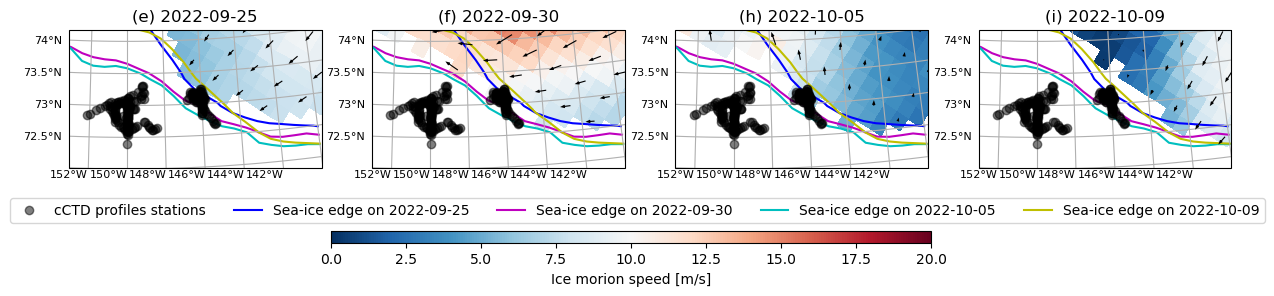

In [317]:
lon0=-150
lonmapmin=-152
lonmapmax=-140
latmapmin=72
latmapmax=74
titleLabel = ['(e)','(f)','(h)','(i)']
fig = plt.figure(figsize=[15, 6])#[15,6]
for i in np.arange(i_sels.size):
    ax = fig.add_subplot(1, 4, i+1, projection=ccrs.Stereographic(central_longitude=-150))
    #ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree())
    ax.set_extent([-153, -140, 72, 74], crs=ccrs.PlateCarree())
    #-----------------------------------------------------------------------------------
    land = cartopy.feature.NaturalEarthFeature(
                category='physical',
                name='land',
                scale='50m',
                facecolor='#dddddd',
                edgecolor='none')
    #-----------------------------------------------------------------------------------
    ax.add_feature(land);ax.coastlines('10m')
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False;gl.right_labels = False
    gl.xlabel_style = {'size': 8, 'color': 'k','rotation':0}
    gl.ylabel_style = {'size': 8, 'color': 'k','rotation':0}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
    gl.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
#     ax.set_xlim([-155,-140])
    #-----------------------------------------------------------------------------------
    speed =  np.sqrt(np.array(U[i_sels[i],:,:].squeeze())**2 + np.array(V[i_sels[i],:,:].squeeze())**2)
    cb = ax.pcolormesh(ds.x, ds.y, speed,transform=EASE_North(),
               vmin=0, vmax=20, cmap='RdBu_r')#, alpha=.5
    #-----------------------------------------------------------------------------------
    k=2#4
    s=200#500
    ax.quiver(ds.x[::k], ds.y[::k], np.array(U[i_sels[i],::k,::k].squeeze()),
                   np.array(V[i_sels[i],::k,::k].squeeze()),transform=EASE_North(),
                   scale=s,width=0.0045, headwidth=3, headlength=4, zorder=3, color='k')
    datestr=str(np.array(U.time[i_sels[i]].values))[:10]
    plt.title(titleLabel[i]+" "+datestr)
    #-----------------------------------------------------------------------------------
    ## Plotting CTD stations positions
    ### All CTD
    ax.plot(lon_ctd[Igoodvar],lat_ctd[Igoodvar],'ok',transform=ccrs.Geodetic(), zorder=3,
            alpha=.5,label="cCTD profiles stations")
    ### Good simu time series
    #ax.plot(lon_ctd[Igoodvar],lat_ctd[Igoodvar],'og',transform=ccrs.Geodetic(), zorder=3)
    ### Early-slow
    #ax.plot(lon_ctd[ESIgrowth],lat_ctd[ESIgrowth],'ob',transform=ccrs.Geodetic(), zorder=3,label="Early-slow")
    ### Late-fast
    #ax.plot(lon_ctd[LFIgrowth],lat_ctd[LFIgrowth],'or',transform=ccrs.Geodetic(), zorder=3,label="Late-fast")
    #plt.legend()
    #-----------------------------------------------------------------------------------
    ## ploting of sea-ice eadge
    ### curves color
    CurvCollor = ["b","m","c","y"]
    if i == 3:
        ax.legend(bbox_to_anchor=(-1.35, -.45),ncol=5,loc="lower center")
    for iedge in np.arange(1,len(TagTime_stand_edge)):
        # nan filter var
        inonan = np.where(~np.isnan(Sea_ice_edge_FrSeaIce_lon[:,iedge]))[0]
        ax.plot(Sea_ice_edge_FrSeaIce_lon[:,iedge][inonan],Sea_ice_edge_FrSeaIce_lat[:,iedge][inonan],
                 '-'+CurvCollor[iedge-1],transform=ccrs.Geodetic(),
                 label="Sea-ice edge on "+TagTime_stand[iedge-1])
        if i == 3:
#             ax.legend(bbox_to_anchor=(-.75, -.35),ncol=4,loc="lower center")
            ax.legend(bbox_to_anchor=(-1.35, -.45),ncol=5,loc="lower center")
    #-----------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.3, 0.255, 0.4, 0.02])
# cbaxes = fig.add_axes([0.3, -0.1, 0.4, 0.02])
cbar = fig.colorbar(cb,cax=cbaxes,fraction=0.033, pad=0.04, label="Ice morion speed [m/s]", 
                    orientation="horizontal",shrink=.75) 

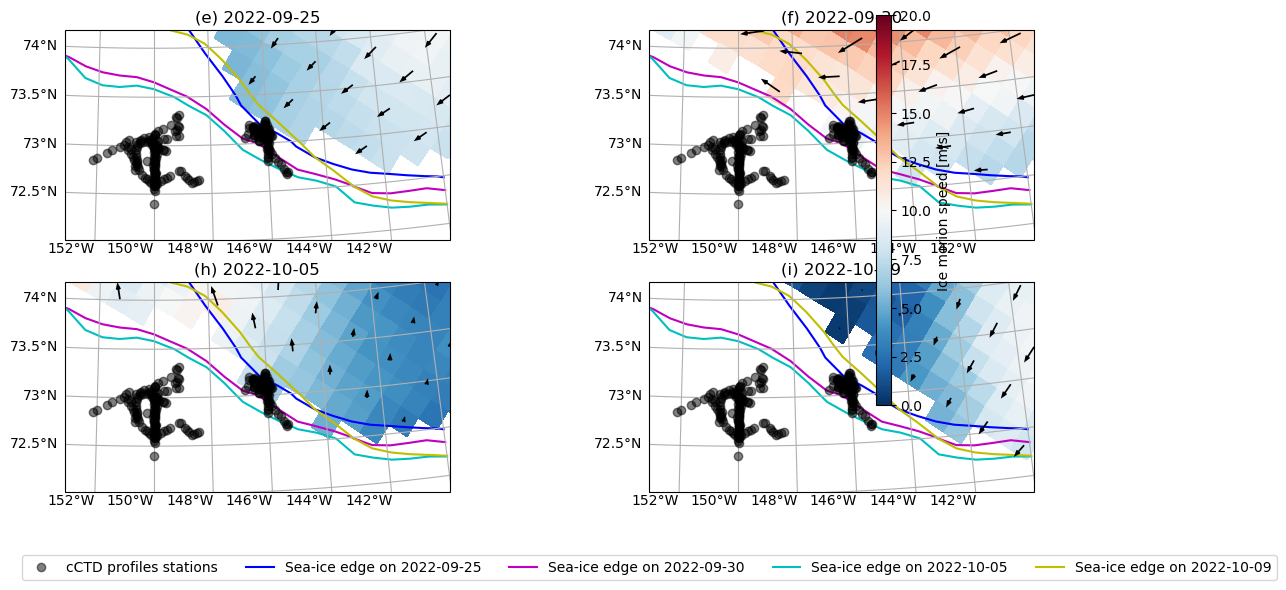

In [334]:
lon0=-150
lonmapmin=-152
lonmapmax=-140
latmapmin=72
latmapmax=74
titleLabel = ['(e)','(f)','(h)','(i)']
fig = plt.figure(figsize=[15, 6])#[15,6]
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.01)
for i in np.arange(i_sels.size):
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.Stereographic(central_longitude=-150))
    #ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree())
    ax.set_extent([-153, -140, 72, 74], crs=ccrs.PlateCarree())
    #-----------------------------------------------------------------------------------
    land = cartopy.feature.NaturalEarthFeature(
                category='physical',
                name='land',
                scale='50m',
                facecolor='#dddddd',
                edgecolor='none')
    #-----------------------------------------------------------------------------------
    ax.add_feature(land);ax.coastlines('10m')
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False;gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'k','rotation':0}
    gl.ylabel_style = {'size': 10, 'color': 'k','rotation':0}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
    gl.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
#     ax.set_xlim([-155,-140])
    #-----------------------------------------------------------------------------------
    speed =  np.sqrt(np.array(U[i_sels[i],:,:].squeeze())**2 + np.array(V[i_sels[i],:,:].squeeze())**2)
    cb = ax.pcolormesh(ds.x, ds.y, speed,transform=EASE_North(),
               vmin=0, vmax=20, cmap='RdBu_r')#, alpha=.5
    #-----------------------------------------------------------------------------------
    k=2#4
    s=200#500
    ax.quiver(ds.x[::k], ds.y[::k], np.array(U[i_sels[i],::k,::k].squeeze()),
                   np.array(V[i_sels[i],::k,::k].squeeze()),transform=EASE_North(),
                   scale=s,width=0.0045, headwidth=3, headlength=4, zorder=3, color='k')
    datestr=str(np.array(U.time[i_sels[i]].values))[:10]
    plt.title(titleLabel[i]+" "+datestr)
    #-----------------------------------------------------------------------------------
    ## Plotting CTD stations positions
    ### All CTD
    ax.plot(lon_ctd[Igoodvar],lat_ctd[Igoodvar],'ok',transform=ccrs.Geodetic(), zorder=3,
            alpha=.5,label="cCTD profiles stations")
    ### Good simu time series
    #ax.plot(lon_ctd[Igoodvar],lat_ctd[Igoodvar],'og',transform=ccrs.Geodetic(), zorder=3)
    ### Early-slow
    #ax.plot(lon_ctd[ESIgrowth],lat_ctd[ESIgrowth],'ob',transform=ccrs.Geodetic(), zorder=3,label="Early-slow")
    ### Late-fast
    #ax.plot(lon_ctd[LFIgrowth],lat_ctd[LFIgrowth],'or',transform=ccrs.Geodetic(), zorder=3,label="Late-fast")
    #plt.legend()
    #-----------------------------------------------------------------------------------
    ## ploting of sea-ice eadge
    ### curves color
    CurvCollor = ["b","m","c","y"]
    if i == 3:
        ax.legend(bbox_to_anchor=(-1.35, -.45),ncol=5,loc="lower center")
    for iedge in np.arange(1,len(TagTime_stand_edge)):
        # nan filter var
        inonan = np.where(~np.isnan(Sea_ice_edge_FrSeaIce_lon[:,iedge]))[0]
        ax.plot(Sea_ice_edge_FrSeaIce_lon[:,iedge][inonan],Sea_ice_edge_FrSeaIce_lat[:,iedge][inonan],
                 '-'+CurvCollor[iedge-1],transform=ccrs.Geodetic(),
                 label="Sea-ice edge on "+TagTime_stand[iedge-1])
        if i == 3:
#             ax.legend(bbox_to_anchor=(-.75, -.35),ncol=4,loc="lower center")
#             ax.legend(bbox_to_anchor=(-1.35, -.45),ncol=5,loc="lower center")
            ax.legend(bbox_to_anchor=(0, -.45),ncol=5,loc="lower center")
    #-----------------------------------------------------------------------------------
cbaxes = fig.add_axes([0.73, 0.255, 0.01, 0.65])
# cbaxes = fig.add_axes([0.3, -0.1, 0.4, 0.02])
cbar = fig.colorbar(cb,cax=cbaxes,fraction=0.033, pad=0.04, label="Ice morion speed [m/s]", 
                    orientation="vertical",shrink=.75) 

In [302]:
3000*12

36000

In [212]:
TagTime_stand

['2022-09-25', '2022-09-30', '2022-10-05']

In [201]:
np.arange(1,len(TagTime_stand_edge))

array([1, 2, 3])

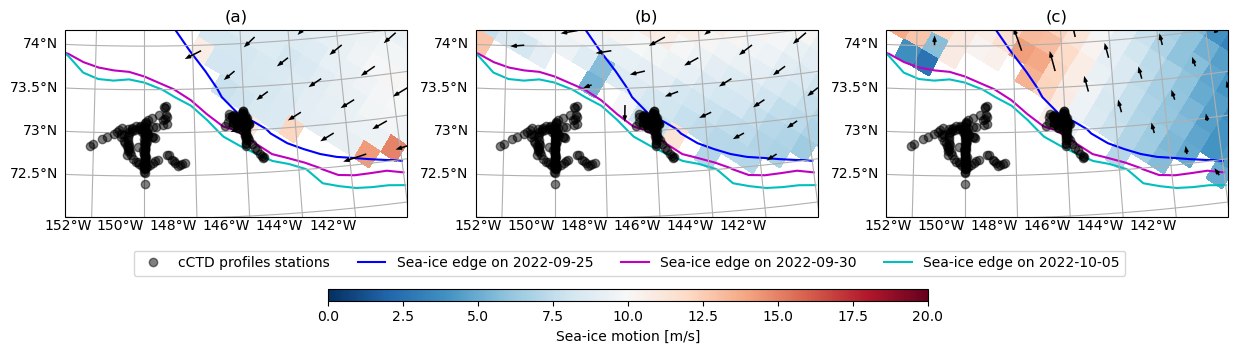

In [269]:
lon0=-150
lonmapmin=-152
lonmapmax=-140
latmapmin=72
latmapmax=74
titleLabel = ['(a)','(b)','(c)']
fig = plt.figure(figsize=[15, 6])
for i in np.arange(3):
    ax = fig.add_subplot(1, 3, i+1, projection=ccrs.Stereographic(central_longitude=lon0))
    #ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree())
#     ax.set_extent([-152, -140, 72, 74], crs=ccrs.PlateCarree())
    ax.set_extent([-153, -140, 72, 74], crs=ccrs.PlateCarree())
    #-----------------------------------------------------------------------------------
    land = cartopy.feature.NaturalEarthFeature(
                category='physical',
                name='land',
                scale='50m',
                facecolor='#dddddd',
                edgecolor='none')
    #-----------------------------------------------------------------------------------
    ax.add_feature(land);ax.coastlines('10m')
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False;gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'k','rotation':0}
    gl.ylabel_style = {'size': 10, 'color': 'k','rotation':0}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(lonmapmin-10,lonmapmax+15,2))
    gl.ylocator = mticker.FixedLocator(np.arange(latmapmin-1,latmapmax+1,0.5))
    #-----------------------------------------------------------------------------------
    ## Tree days average calculation
    U_3d_mean = np.nanmean(np.array(U[np.arange(i_sels[i]-1,i_sels[i]+2),:,:].squeeze()),axis=0)
    V_3d_mean = np.nanmean(np.array(V[np.arange(i_sels[i]-1,i_sels[i]+2),:,:].squeeze()),axis=0)
    #-----------------------------------------------------------------------------------
    speed =  np.sqrt(np.array(U_3d_mean)**2 + np.array(V_3d_mean)**2)
    cb = ax.pcolormesh(ds.x, ds.y, speed,transform=EASE_North(),
               vmin=0, vmax=20, cmap='RdBu_r')#, alpha=.5
    #-----------------------------------------------------------------------------------
    k=2#4
    s=200
    ax.quiver(ds.x[::k], ds.y[::k], np.array(U_3d_mean[::k,::k].squeeze()),
                   np.array(V_3d_mean[::k,::k].squeeze()),transform=EASE_North(),
                   scale=s,width=0.0045, headwidth=3, headlength=4, zorder=3, color='k')
    datestr=str(np.array(U.time[i_sels[i]].values))[:10]
    #plt.title(datestr)
    plt.title(titleLabel[i])
    #-----------------------------------------------------------------------------------
    ## Plotting CTD stations positions
    ### All CTD
    ax.plot(lon_ctd[Igoodvar],lat_ctd[Igoodvar],'ok',transform=ccrs.Geodetic(), zorder=3,
            alpha=.5,label="cCTD profiles stations")
    ### Good simu time series
    #ax.plot(lon_ctd[Igoodvar],lat_ctd[Igoodvar],'og',transform=ccrs.Geodetic(), zorder=3)
    ### Early-slow
    #ax.plot(lon_ctd[ESIgrowth],lat_ctd[ESIgrowth],'ob',transform=ccrs.Geodetic(), zorder=3,label="Early-slow")
    ### Late-fast
    #ax.plot(lon_ctd[LFIgrowth],lat_ctd[LFIgrowth],'or',transform=ccrs.Geodetic(), zorder=3,label="Late-fast")
    #plt.legend()
    #-----------------------------------------------------------------------------------
    ## ploting of sea-ice eadge
    ### curves color
    CurvCollor = ["b","m","c"]
    if i == 2:
        ax.legend(bbox_to_anchor=(-.75, -.35),ncol=4,loc="lower center")
    for iedge in np.arange(1,len(TagTime_stand_edge)):
        # nan filter var
        inonan = np.where(~np.isnan(Sea_ice_edge_FrSeaIce_lon[:,iedge]))[0]
        ax.plot(Sea_ice_edge_FrSeaIce_lon[:,iedge][inonan],Sea_ice_edge_FrSeaIce_lat[:,iedge][inonan],
                 '-'+CurvCollor[iedge-1],transform=ccrs.Geodetic(),
                 label="Sea-ice edge on "+TagTime_stand[iedge-1])
        if i == 2:
            ax.legend(bbox_to_anchor=(-.75, -.35),ncol=4,loc="lower center")

cbaxes = fig.add_axes([0.3, 0.2, 0.4, 0.02])
cbar = fig.colorbar(cb,cax=cbaxes,fraction=0.033, pad=0.04, label="Sea-ice motion [m/s]", 
                    orientation="horizontal",shrink=.75) 

['(a)', 'b', 'c']

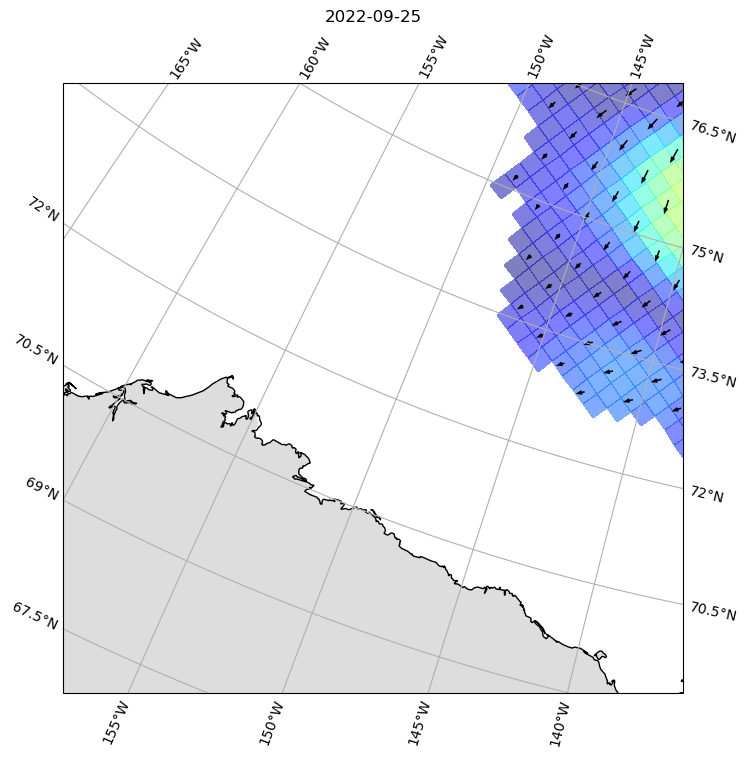

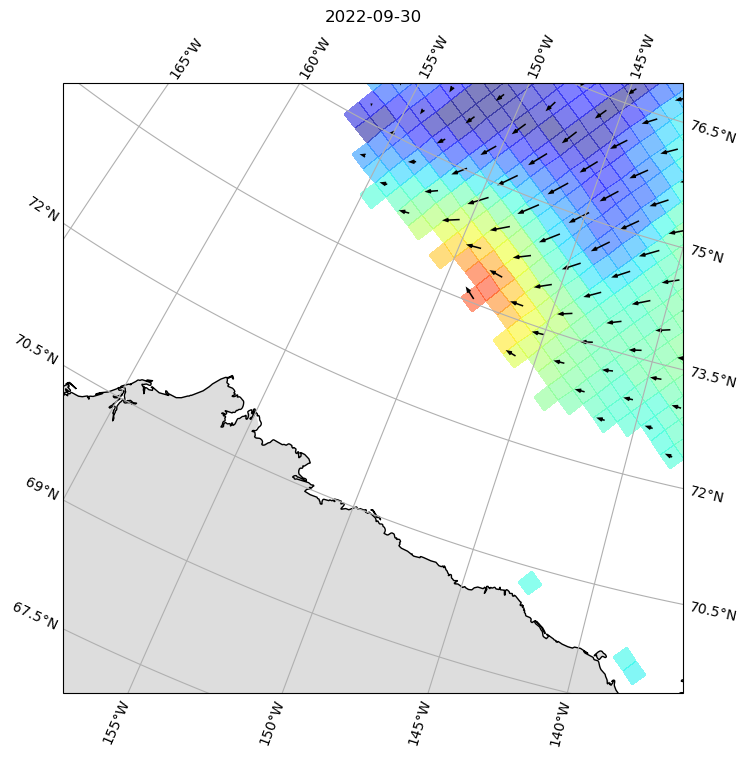

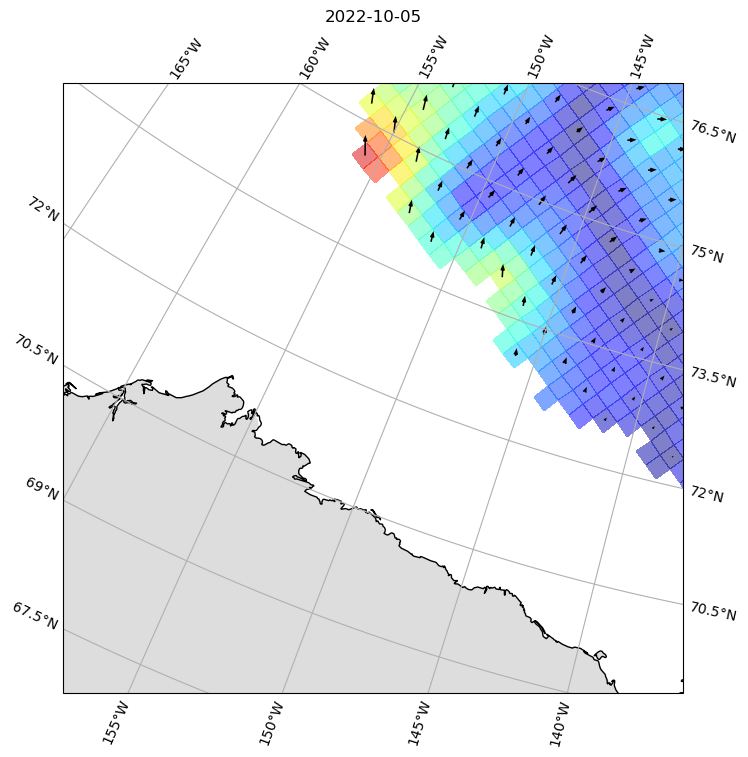

In [39]:
for i_sel in i_sels:

    fig, ax = plt.subplots(figsize=(8,8),
                           subplot_kw={'projection': ccrs.Stereographic(central_longitude=-120)})
    #ax.set_extent([-180, -100, 65, 90], crs=ccrs.PlateCarree())
    ax.set_extent([lonmapmin, lonmapmax, latmapmin, latmapmax], crs=ccrs.PlateCarree())
    #----------------------------------------------------------
    land = cartopy.feature.NaturalEarthFeature(
                category='physical',
                name='land',
                scale='50m',
                facecolor='#dddddd',
                edgecolor='none')
    #----------------------------------------------------------
    ax.add_feature(land)
    ax.coastlines('10m')
    #----------------------------------------------------------
    speed =  np.sqrt(np.array(U[i_sel,:,:].squeeze())**2 + np.array(U[i_sel,:,:].squeeze())**2)
    ax.pcolormesh(ds.x, ds.y, speed,transform=EASE_North(),
               vmin=0, vmax=20, cmap='jet', alpha=.5)
    #----------------------------------------------------------
    k=2#4
    s=500
    ax.quiver(ds.x[::k], ds.y[::k], np.array(U[i_sel,::k,::k].squeeze()),
                   np.array(V[i_sel,::k,::k].squeeze()),transform=EASE_North(),
                   scale=s,width=0.0025, headwidth=3, headlength=4, zorder=1, color='k')
    
    datestr=str(np.array(U.time[i_sel].values))[:10]
    plt.title(datestr)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)

# Building the proper projection coordinates system

# Colocation sea-ice motion vectors data on sea-ice edge

In [59]:
lons=Sea_ice_edge_FrSeaIce_lon[:,i][inonan]
lats=Sea_ice_edge_FrSeaIce_lat[:,i][inonan]

array([-165.        , -164.375     , -163.75      , -163.15792181,
       -163.125     , -162.5       , -161.875     , -161.25      ,
       -160.625     , -160.        , -159.375     , -158.75      ,
       -158.125     , -158.04679233, -157.5       , -156.875     ,
       -156.25      , -155.625     , -155.        , -154.88825262,
       -155.        , -155.34981685, -155.625     , -156.25      ,
       -156.64420768, -156.875     , -157.39651639, -157.44469487,
       -156.875     , -156.55263158, -156.25      , -155.625     ,
       -155.        , -154.375     , -153.75      , -153.69854071,
       -153.125     , -152.5       , -151.875     , -151.25      ,
       -150.625     , -150.        , -149.375     , -149.27328244,
       -148.75      , -148.125     , -147.5       , -147.06643836,
       -146.875     , -146.25      , -145.625     , -145.        ,
       -144.375     , -143.75      , -143.70636433, -143.125     ,
       -142.5       , -141.875     , -141.25      , -140.625  

In [73]:
for i_selT in i_sels:
    a=np.sum(np.isnan(U[i_selT,:,:])).values
    b=np.sum(~np.isnan(U[i_selT,:,:])).values
    print(a,b)

123467 6854
123299 7022
122973 7348


In [78]:
50*100

5000

for i_selT in i_sels:
    plt.figure()
    tmp = U[i_selT,:,:].squeeze()
    plt.imshow(tmp)


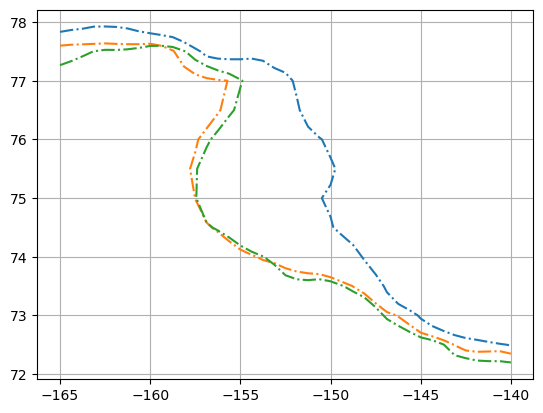

In [51]:
R_range = 50000
# time colocation (u,v) vs ice edge time
for i in np.arange(3)+ 1:
    i_selT = np.where(np.array(Time_imo) == TagTime_stand[i])[0]
    # nan filter var
    inonan = np.where(~np.isnan(Sea_ice_edge_FrSeaIce_lon[:,i]))[0]

    IceMotion_grid_def = GridDefinition(lons=lon, lats=lat)#--------------------------|
    SWATH_Ice_Contours = geometry.SwathDefinition(lons=Sea_ice_edge_FrSeaIce_lon[:,i][inonan],
                                                  lats=Sea_ice_edge_FrSeaIce_lat[:,i][inonan])#-----|



    u_co  = kd_tree.resample_nearest(IceMotion_grid_def,np.array(U[i_selT,:,:].squeeze()),
                                     SWATH_Ice_Contours,radius_of_influence = R_range,fill_value=np.nan)

    v_co  = kd_tree.resample_nearest(IceMotion_grid_def,np.array(V[i_selT,:,:].squeeze()),
                                     SWATH_Ice_Contours,radius_of_influence = R_range,fill_value=np.nan)
    ## ploting
    plt.plot(Sea_ice_edge_FrSeaIce_lon[:,i][inonan],Sea_ice_edge_FrSeaIce_lat[:,i][inonan],'-.')

    plt.quiver(Sea_ice_edge_FrSeaIce_lon[:,i][inonan],Sea_ice_edge_FrSeaIce_lat[:,i][inonan],
              np.array(u_co),np.array(v_co),scale=150.,width=0.005, headwidth=3, headlength=4,zorder=1)

    #plt.xlim(-151,-145);plt.ylim(72,80)
    #plt.xlim(-151,-145);plt.ylim(72,74)
    plt.grid(.5)

(72.0, 74.0)

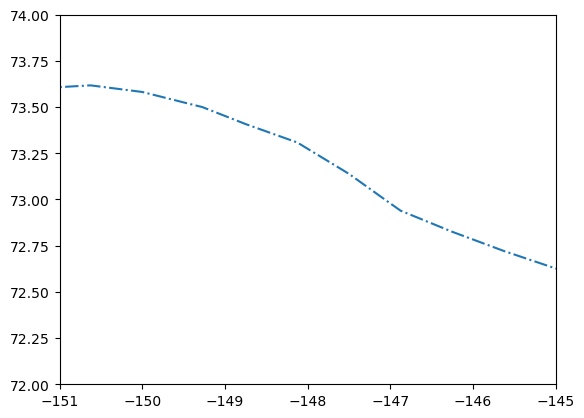

In [48]:
plt.plot(Sea_ice_edge_FrSeaIce_lon[:,i][inonan],Sea_ice_edge_FrSeaIce_lat[:,i][inonan],'-.')

plt.quiver(Sea_ice_edge_FrSeaIce_lon[:,i][inonan],Sea_ice_edge_FrSeaIce_lat[:,i][inonan],
          np.array(u_co),np.array(v_co),scale=150.,width=0.005, headwidth=3, headlength=4,zorder=1)

#plt.xlim(-151,-145);plt.ylim(72,80)
plt.xlim(-151,-145);plt.ylim(72,74)